# Benchmark the use of k-mers for pangenomics

In [ ]:
# install pagoo:
remotes::install_github("rstudio/httpuv")

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("iferres/pagoo")

In [1]:
setwd("..")

In [3]:
library(readr)
library(dplyr)
library(purrr)
library(tidyr)
library(tibble)
library(janitor)
library(broom)
library(stringi)
library(feather)
library(ggplot2)
library(pagoo)
library(ggtree)
library(stringr)
library(ggpubr)

## Functions

In [4]:
compare_summary_stats <- function(roary_pagoo, kmer_pagoo){
  all_summary <- roary_pagoo$summary_stats %>%
    as.data.frame() %>%
    select(Category, roary = Number) %>%
    left_join(as.data.frame(kmer_pagoo$summary_stats), by = "Category") %>%
    select(Category, roary, kmers = Number)
  
  all_summary %>%
    pivot_longer(cols = -Category, names_to = "method", values_to = "units") %>%
    pivot_wider(id_cols = c(method), names_from = Category, values_from = units) %>%
    mutate(core_pct = Core/Total) %>%
    mutate(shell_pct = Shell/Total) %>%
    mutate(cloud_pct = Cloud/Total) %>%
    pivot_longer(cols = -method)
}

In [5]:
summary_stats_to_df <- function(roary_pagoo, kmer_pagoo, species){
  roary <-  roary_pagoo$summary_stats %>%
    as.data.frame() %>%
    select(Category, roary = Number) %>%
    pivot_longer(cols = -Category, names_to = "method", values_to = "units") %>%
    pivot_wider(id_cols = c(method), names_from = Category, values_from = units) %>%
    mutate(roary_core_pct = Core/Total) %>%
    mutate(roary_shell_pct = Shell/Total) %>%
    mutate(roary_cloud_pct = Cloud/Total) %>%
    #rename(roary_total = Total, roary_core = Core, roary_shell = Shell, roary_cloud = Cloud) %>%
    select(roary_total = Total, roary_core = Core, roary_shell = Shell, 
           roary_cloud = Cloud, roary_core_pct, roary_shell_pct, roary_cloud_pct)
  
  kmer <- kmer_pagoo$summary_stats %>%
    as.data.frame() %>%
    select(Category, kmer = Number) %>%
    pivot_longer(cols = -Category, names_to = "method", values_to = "units") %>%
    pivot_wider(id_cols = c(method), names_from = Category, values_from = units) %>%
    mutate(kmer_core_pct = Core/Total) %>%
    mutate(kmer_shell_pct = Shell/Total) %>%
    mutate(kmer_cloud_pct = Cloud/Total) %>%
    select(kmer_total = Total, kmer_core = Core, kmer_shell = Shell, kmer_cloud = Cloud,
           kmer_core_pct, kmer_shell_pct, kmer_cloud_pct)
  
  summary_stats <- cbind(roary, kmer)
  summary_stats$species <- species
  return(summary_stats)
}

In [6]:
read_roary_presence_absence <- function(path){
  roary <- read_csv(path, show_col_types = F) %>%
    clean_names() %>%
    select(-non_unique_gene_name, -annotation, -no_isolates, -no_sequences, 
           -avg_sequences_per_isolate, -genome_fragment, -order_within_fragment, 
           -accessory_fragment, -accessory_order_with_fragment, -qc, 
           -min_group_size_nuc, -max_group_size_nuc, -avg_group_size_nuc) %>%
    as.data.frame() %>%
    column_to_rownames("gene")
  # replace gene name with 1, NA with 0
  roary[] <- lapply(roary, function(x) as.integer(!is.na(x)))
  roary <- as.data.frame(t(roary)) # switch orientation genome (rows) x genes (columns)
}

In [7]:
read_mers_presence_absence <- function(path) {
  mers <- arrow::read_feather(path)
  #mers$acc <- gsub("_k10_scaled1", "", mers$acc)
  mers$acc <- make_clean_names(mers$acc)
  mers <- as.data.frame(mers)
  rownames(mers) <- mers$acc
  mers <- mers[ , -ncol(mers)]
}

In [8]:
read_long_sketch_table_as_pagoo <- function(path){
  sketch_table <- read_csv(path, show_col_types = F)
  sketch_table <- sketch_table %>%
    select(gene    = minhash, 
           org     = acc,
           cluster = minhash) 
  p <- pagoo(data = as.data.frame(sketch_table))
  return(p)
}

In [9]:
correlate_total_per_genome <- function(roary, mers, species, alpha, ksize, scaled){
  plot_params <- paste0("(", alpha, ", k=", ksize, ", scaled=", scaled, ")")
  
  total_genes_per_genome <- rowSums(roary)
  total_mers_per_genome <- rowSums(mers)
  
  total_per_genome <- data.frame(total_genes_per_genome, total_mers_per_genome)
  
  total_per_genome <- total_per_genome %>%
    rownames_to_column("genome") 
  
  lm_result <- lm(total_genes_per_genome ~ total_mers_per_genome, data = total_per_genome) %>%
    glance() %>%
    mutate(species = species)
  
  r_squared <- round(lm_result$r.squared, digits = 2)
  p_value <- ifelse(lm_result$p.value > 0.001, 
                    paste0("= ", round(lm_result$p.value, digits = 3)), 
                    "< 0.001")
  
  plt <- ggplot(total_per_genome, aes(x = total_genes_per_genome, y = total_mers_per_genome)) +
    geom_point() +
    theme_minimal() +
    theme(axis.title = element_text(size = 8),
          plot.title = element_text(size = 9),
          plot.subtitle = element_text(size = 8),
          axis.text = element_text(size = 7)) +
    labs(x = "genes per genome", y = paste0("k-mers per genome ", plot_params), 
         title = species,
         subtitle = paste0("R-squared:  ", r_squared, " (p ", p_value, ")"))
  
  return(list(lm_result = lm_result, plt = plt))
}

In [10]:
correlate_total_per_genome_mmazei <- function(roary, mers, species, alpha, ksize, scaled){
  plot_params <- paste0("(", alpha, ", k=", ksize, ", scaled=", scaled, ")")
  
  total_genes_per_genome <- rowSums(roary)
  total_mers_per_genome <- rowSums(mers)
  
  total_per_genome <- data.frame(total_genes_per_genome, total_mers_per_genome)
  
  total_per_genome <- total_per_genome %>%
    rownames_to_column("genome") %>%
    filter(genome != "gca_001315865_1")
  
  lm_result <- lm(total_genes_per_genome ~ total_mers_per_genome, data = total_per_genome) %>%
    glance() %>%
    mutate(species = species)
  
  r_squared <- round(lm_result$r.squared, digits = 2)
  p_value <- ifelse(lm_result$p.value > 0.001, 
                    paste0("= ", round(lm_result$p.value, digits = 3)), 
                    "< 0.001")
  
  plt <- ggplot(total_per_genome, aes(x = total_genes_per_genome, y = total_mers_per_genome)) +
    geom_point() +
    theme_minimal() +
    theme(axis.title = element_text(size = 8),
          plot.title = element_text(size = 9),
          plot.subtitle = element_text(size = 8),
          axis.text = element_text(size = 7)) +
    labs(x = "genes per genome", y = paste0("k-mers per genome ", plot_params), 
         title = species,
         subtitle = paste0("R-squared:  ", r_squared, " (p ", p_value, ")"))
  
  return(list(lm_result = lm_result, plt = plt))
}

## Read in metadata

In [11]:
# genome metadata
# filter to orpheum sim metadata (otherwise more species are represented)
orph_sim_gtdb_info <- read_tsv("../2021-orpheum-sim/inputs/gtdb_metadata.tsv", show_col_types = F) %>%
  select(species_no_space)
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F) %>%
  filter(species_no_space %in% orph_sim_gtdb_info$species_no_space)

In [12]:
# genbank assembly summary
destfile <- "inputs/assembly_summary_genbank.txt"
url <- "https://ftp.ncbi.nlm.nih.gov/genomes/genbank/assembly_summary_genbank.txt"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}

genbank <- read_tsv(destfile, skip = 1, show_col_types = F) %>%
  select(assembly_accession = `# assembly_accession`, excluded_from_refseq)

genbank <- genbank %>%
  mutate(assembly_accession_minus_version = gsub("\\.[1-9].*", "", assembly_accession)) %>%
  mutate(assembly_accession_minus_prefix = gsub("GC[AF]_", "", assembly_accession_minus_version))

In [13]:
# pangenome accessions
pangenome_genome_accessions <- Sys.glob("outputs/sourmash_sketch_tables/protein-k10_scaled100/*_long.csv") %>%
  set_names() %>%
  map_dfr(read_csv, show_col_types = F, .id = "species") %>%
  select(species, acc) %>%
  distinct() %>%
  #mutate(species = gsub("outputs\\/sourmash_sketch_tables\\/protein-k10_scaled100\\/", "", species)) %>%
  mutate(species = gsub("_long\\.csv", "", basename(species))) %>%
  filter(species %in% metadata$species_no_space)

pangenome_genome_accessions <- pangenome_genome_accessions %>%
  mutate(assembly_accession_minus_version = gsub("\\.[1-9].*", "", acc)) %>%
  mutate(assembly_accession_minus_prefix = gsub("GC[FA]_", "", assembly_accession_minus_version)) %>%
  left_join(genbank, by = "assembly_accession_minus_prefix")

## Parameters do not influence similarity between sketch-based and gene-based pangenome

### Initial: contains genomes with many frameshifted proteins

In [14]:
# summarize parameters
r2_genes <- Sys.glob("outputs/correlate_pan_units/*_scaled100*/*_genes.tsv") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = F, .id = "species")

r2_genes <- r2_genes %>%
  mutate(species = gsub("outputs\\/correlate_pan_units\\/", "", species)) %>%
  mutate(species = gsub("_genes\\.tsv", "", species)) %>%
  separate(species, into = c("parameters", "species"), sep = "/") %>%
  separate(parameters, into = c("alphabet", "parameters"), sep = "-") %>%
  separate(parameters, into = c("ksize", "scaled"), sep = "_") %>%
  mutate(ksize = gsub("k", "", ksize)) %>%
  mutate(scaled = gsub("scaled", "", scaled)) %>%
  select(alphabet, ksize, scaled, species, genes_r2 = r.squared) %>%
  filter(species %in% metadata$species_no_space)

r2_unique <- Sys.glob("outputs/correlate_pan_units/*_scaled100*/*_unique.tsv") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = F, .id = "species")  

r2_unique <- r2_unique %>%
  mutate(species = gsub("outputs\\/correlate_pan_units\\/", "", species)) %>%
  mutate(species = gsub("_unique\\.tsv", "", species)) %>%
  separate(species, into = c("parameters", "species"), sep = "/") %>%
  separate(parameters, into = c("alphabet", "parameters"), sep = "-") %>%
  separate(parameters, into = c("ksize", "scaled"), sep = "_") %>%
  mutate(ksize = gsub("k", "", ksize)) %>%
  mutate(scaled = gsub("scaled", "", scaled)) %>%
  select(alphabet, ksize, scaled, species, unique_r2 = r.squared) %>%
  filter(species %in% metadata$species_no_space)

r_mantel <- Sys.glob("outputs/correlate_pan_units/*_scaled100*/*_mantel.tsv") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = F, .id = "species")  

r_mantel <- r_mantel %>%
  mutate(species = gsub("outputs\\/correlate_pan_units\\/", "", species)) %>%
  mutate(species = gsub("_mantel\\.tsv", "", species)) %>%
  separate(species, into = c("parameters", "species"), sep = "/") %>%
  separate(parameters, into = c("alphabet", "parameters"), sep = "-") %>%
  separate(parameters, into = c("ksize", "scaled"), sep = "_") %>%
  mutate(ksize = gsub("k", "", ksize)) %>%
  mutate(scaled = gsub("scaled", "", scaled)) %>%
  select(alphabet, ksize, scaled, species, mantel = statistic) %>%
  filter(species %in% metadata$species_no_space)

results <- left_join(r2_genes, r2_unique) %>%
  left_join(r_mantel)

Joining, by = c("alphabet", "ksize", "scaled", "species")
Joining, by = c("alphabet", "ksize", "scaled", "species")


In [15]:
results_summarized<-results %>%
  group_by(alphabet, ksize, scaled) %>%
  summarize(mean_genes_r2 = mean(genes_r2, na.rm = T),
            mean_unique_r2 = mean(unique_r2, na.rm = T),
            mean_mantel = mean(mantel, na.rm = T))%>%
  arrange(mean_mantel)

results_summarized

`summarise()` has grouped output by 'alphabet', 'ksize'. You can override using the `.groups` argument.


alphabet,ksize,scaled,mean_genes_r2,mean_unique_r2,mean_mantel
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
dna,31,1000,0.7931828,0.7168021,0.8702889
protein,11,100,0.6632419,0.7617394,0.9252990
hp,31,100,0.6301593,0.7537263,0.9254972
protein,9,100,0.6684198,0.7654742,0.9281008
hp,27,100,0.6373181,0.7632385,0.9282437
protein,10,100,0.6603334,0.7641709,0.9282727
dayhoff,17,100,0.6541780,0.7674187,0.9284617
dayhoff,15,100,0.6651690,0.7669873,0.9306878
protein,7,100,0.6743929,0.7656166,0.9317222


In [16]:
results_long2 <- results %>%
  pivot_longer(cols = genes_r2:mantel, names_to = "measurement", values_to = "statistic") %>%
  mutate(ksize = factor(ksize, levels = c("31", "7", "8", "9", "10", "11",
                                          "13", "15", "17", "27"))) %>%
  mutate(alphabet = factor(alphabet, levels = c("dna", "protein", "dayhoff", "hp"))) %>%
  mutate(measurement = factor(measurement, levels = c("genes_r2", "unique_r2", "mantel"))) %>%
  mutate(alpha_ksize = paste0(alphabet, "_", ksize)) %>%
  filter(alpha_ksize != "hp_31") %>%
  filter(alpha_ksize != "dna_31")

box_plt_supp <- ggplot(results_long2, aes(x = ksize, y = statistic, color = alphabet)) +
  geom_boxplot() +
  theme_minimal() +
  theme(axis.title = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.subtitle = element_text(size = 8),
        axis.text = element_text(size = 7),
        legend.position = "right",
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 8)) +
  labs(x = "k-mer size", fill = "encoding") +
  facet_wrap(~measurement, labeller = as_labeller(
    c(genes_r2 = "Total", unique_r2 = "Unique", mantel = "Mantel"))) + 
  scale_color_manual(values = c("#7CAE00", "#00BFC4", "#C77CFF"))

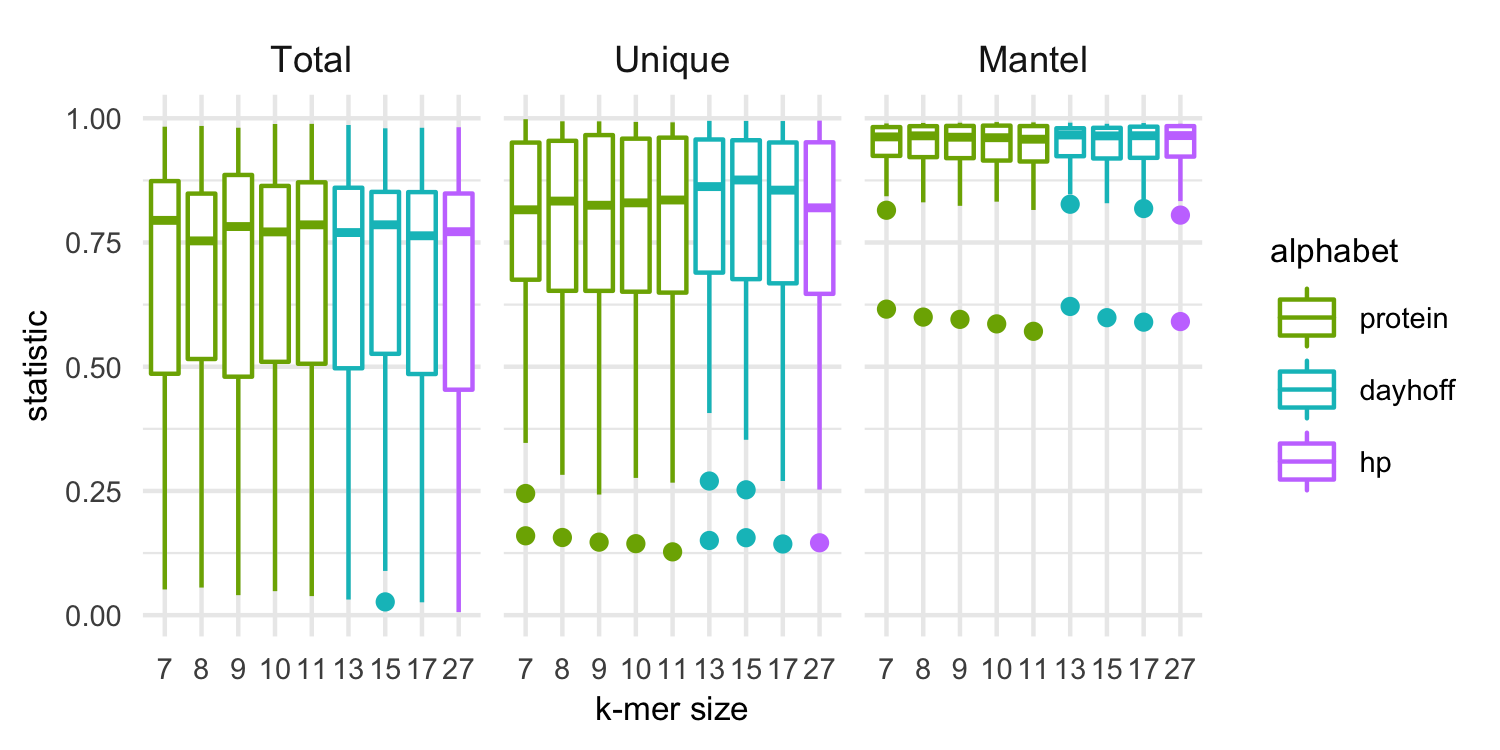

In [17]:
# adjust plot size rendered inline
options(repr.plot.width = 5, repr.plot.height = 2.5, repr.plot.res = 300)

#pdf("box_plt_supp.pdf", height = 2.5, width = 5)
box_plt_supp
#dev.off()

## Pangenomes with low R<sup>2</sup> values contain genomes with many frameshifted proteins

### *M. mazei*

In [18]:
roary_mmazei <- read_roary_presence_absence("outputs/roary/s__Methanosarcina-mazei/gene_presence_absence.csv")
pk10_mmazei <- read_mers_presence_absence("outputs/sourmash_sketch_tables/protein-k10_scaled100/s__Methanosarcina-mazei_wide.feather")

In [19]:
mmazei_corr <- correlate_total_per_genome(roary = roary_mmazei,
                                          mers = pk10_mmazei, 
                                          species = "M. mazei", 
                                          alpha = "protein", 
                                          ksize = 10, 
                                          scaled = 100)

mmazei_corr_rm <- correlate_total_per_genome_mmazei(roary = roary_mmazei,
                                                    mers = pk10_mmazei, 
                                                    species = "M. mazei", 
                                                    alpha = "protein", 
                                                    ksize = 10, 
                                                    scaled = 100)

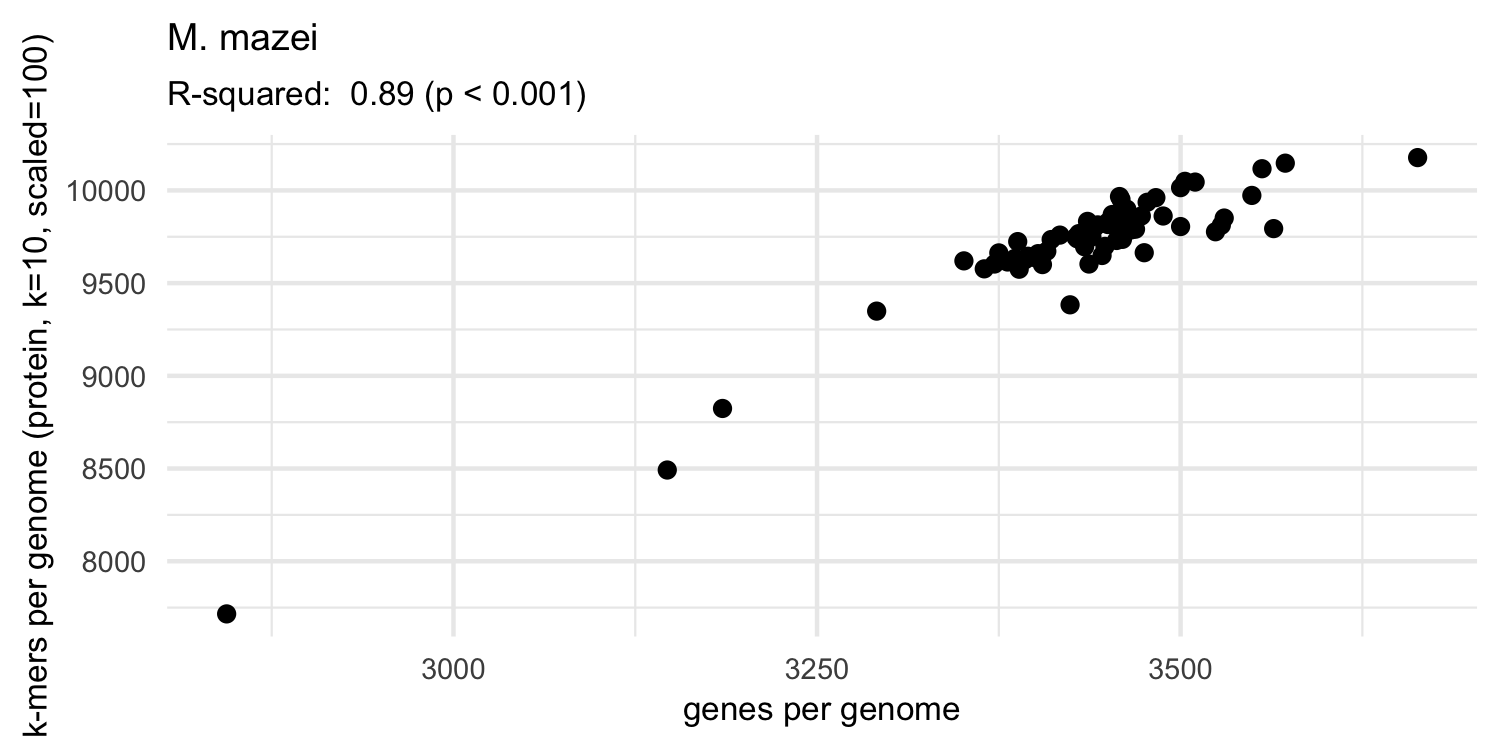

In [20]:
mmazei_corr_rm$plt

### *L. interrogans*

In [21]:
roary_linterrogans <- read_roary_presence_absence("outputs/roary/s__Leptospira-interrogans/gene_presence_absence.csv")
pk10_linterrogans <- read_mers_presence_absence("outputs/sourmash_sketch_tables/protein-k10_scaled100/s__Leptospira-interrogans_wide.feather")

linterrogans_corr <- correlate_total_per_genome(roary = roary_linterrogans,
                                                mers = pk10_linterrogans, 
                                                species = "L. interrogans", 
                                                alpha = "protein", 
                                                ksize = 10, 
                                                scaled = 100)

In [22]:
alpha = "protein"
ksize = 10
scaled = 100
species = "L. interrogans"
mers = pk10_linterrogans
roary = roary_linterrogans

plot_params <- paste0("(", alpha, ", k=", ksize, ", scaled=", scaled, ")")

In [46]:
total_genes_per_genome <- rowSums(roary)
total_mers_per_genome <- rowSums(mers)

total_per_genome <- data.frame(total_genes_per_genome, total_mers_per_genome)

total_per_genome <- total_per_genome %>%
  rownames_to_column("assembly_accession") %>%
  mutate(assembly_accession = stri_replace_last_fixed(assembly_accession, '_', '.')) %>%
  mutate(assembly_accession = gsub("gcf", "GCF", assembly_accession)) %>%
  mutate(assembly_accession = gsub("gca", "GCA", assembly_accession)) %>%
  mutate(assembly_accession_minus_version = gsub("\\.[1-9].*", "", assembly_accession)) %>%
  mutate(assembly_accession_minus_prefix = gsub("GC[FA]_", "", assembly_accession_minus_version)) %>%
  left_join(genbank, by = "assembly_accession_minus_prefix")
  
lm_result <- lm(total_mers_per_genome ~ total_genes_per_genome, data = total_per_genome) %>%
  glance() %>%
  mutate(species = species)

r_squared <- round(lm_result$r.squared, digits = 2)
p_value <- ifelse(lm_result$p.value > 0.001, 
                  paste0("= ", round(lm_result$p.value, digits = 3)), 
                  "< 0.001")

lm_result

lm_result_tidy <- lm(total_mers_per_genome ~ total_genes_per_genome, data = total_per_genome) %>% 
  tidy()


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs,species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
0.1171431,0.1143404,347.1965,41.79623,3.855018e-10,1,-2303.216,4612.431,4623.708,37971797,315,317,L. interrogans


In [43]:
total_per_genome_rm <- total_per_genome %>%
  filter(is.na(excluded_from_refseq))

lm_result_rm <- lm(total_mers_per_genome ~ total_genes_per_genome, data = total_per_genome_rm) %>%
  glance() %>%
  mutate(species = species)

r_squared_rm <- round(lm_result_rm$r.squared, digits = 2)
p_value_rm <- ifelse(lm_result_rm$p.value > 0.001, 
                  paste0("= ", round(lm_result_rm$p.value, digits = 3)), 
                  "< 0.001")

lm_result_rm_tidy <- lm(total_mers_per_genome ~ total_genes_per_genome, data = total_per_genome_rm) %>% 
  tidy()

# plt_rm <- ggplot(total_per_genome_rm, aes(x = total_genes_per_genome, y = total_mers_per_genome,
#                                           label = assembly_accession_minus_prefix,
#                                           color = many_frameshifted_proteins)) +
#   geom_point() +
#   xlim(c(3400, 4600)) + ylim(8800, 12200) +
#   theme_minimal() +
#   theme(axis.title = element_text(size = 8),
#         plot.title = element_text(size = 9,  face = "italic"),
#         plot.subtitle = element_text(size = 8),
#         axis.text = element_text(size = 7)) +
#   labs(x = "genes per genome", y = "", 
#        title = species,
#        subtitle = paste0("R-squared:  ", r_squared_rm, " (p ", p_value_rm, ")"),
#        color = "RefSeq exclusion criteria:\nmany frameshifted proteins") +
#   scale_color_brewer(palette = "Set2") 

In [44]:
lm_result_rm_tidy
lm_result_rm_tidy$estimate[2]

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3954.923989,158.68912174,24.92246,2.884354e-74
total_genes_per_genome,1.929805,0.04304372,44.83361,5.959344e-133


[1] 1.929805

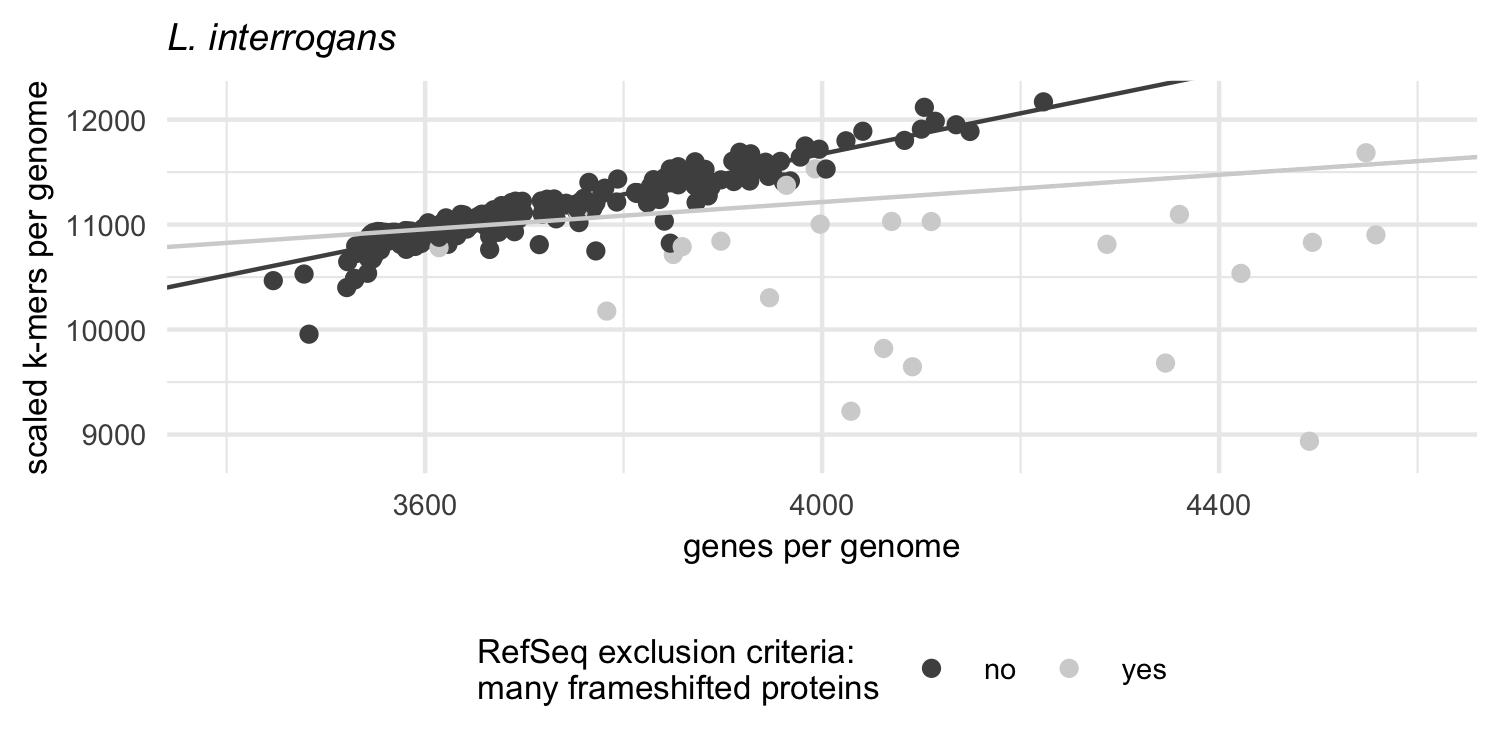

In [47]:
total_per_genome <- total_per_genome %>%
  mutate(many_frameshifted_proteins = ifelse(is.na(excluded_from_refseq), "no", "yes"))
         
plt <- ggplot(total_per_genome, aes(x = total_genes_per_genome, y = total_mers_per_genome,
                                    color = many_frameshifted_proteins, 
                                    label = assembly_accession_minus_prefix)) +
  geom_point() +
  xlim(c(3400, 4600)) + ylim(8800, 12200) +
  theme_minimal() +
  theme(axis.title = element_text(size = 8),
        plot.title = element_text(size = 9, face = "italic"),
        plot.subtitle = element_text(size = 8),
        axis.text = element_text(size = 7), 
        legend.position = "bottom",
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 7)) +
  labs(x = "genes per genome", y = "scaled k-mers per genome", 
       title = species,
       color = "RefSeq exclusion criteria:\nmany frameshifted proteins") +
  scale_color_manual(values = c("grey31", "lightgrey")) +
  geom_abline(slope = lm_result_rm_tidy$estimate[2], intercept = lm_result_rm_tidy$estimate[1], color = "grey31") +
  geom_abline(slope = lm_result_tidy$estimate[2], intercept = lm_result_tidy$estimate[1], color = "lightgrey")

plt

### T test many frame shifted proteins

In [48]:
# T test frame shift

pk10_r2_genes <- r2_genes %>%
  filter(ksize == 10) 

pangenome_genome_num_excluded <- pangenome_genome_accessions %>%
  mutate(many_frameshifted_proteins = grepl("many frameshifted proteins", excluded_from_refseq)) %>%
  filter(many_frameshifted_proteins == TRUE) %>%
  group_by(species) %>%
  tally()

pangenome_genome_num_excluded <- pk10_r2_genes %>%
  left_join(pangenome_genome_num_excluded, by = "species") %>%
  replace_na(list(n = 0)) 

pangenome_genome_num_excluded <- pangenome_genome_num_excluded %>%
  mutate(excluded = ifelse(n > 0, "yes", "no"))

ttest_pangenome_genome_num_excluded <- pangenome_genome_num_excluded  %>% 
  group_by(excluded) %>% 
  nest() %>% 
  spread(key = excluded, value = data) %>% 
  mutate(
    t_test = map2(yes, no, ~{t.test(.x$genes_r2, .y$genes_r2) %>% tidy()}),
    yes = map(yes, nrow),
    no = map(no, nrow)
  ) %>% 
  unnest(cols = c(no, yes, t_test)) 

ttest_pangenome_genome_num_excluded

no,yes,estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
13,10,-0.3597784,0.4569803,0.8167588,-3.617437,0.003185382,12.83837,-0.5749169,-0.14464,Welch Two Sample t-test,two.sided


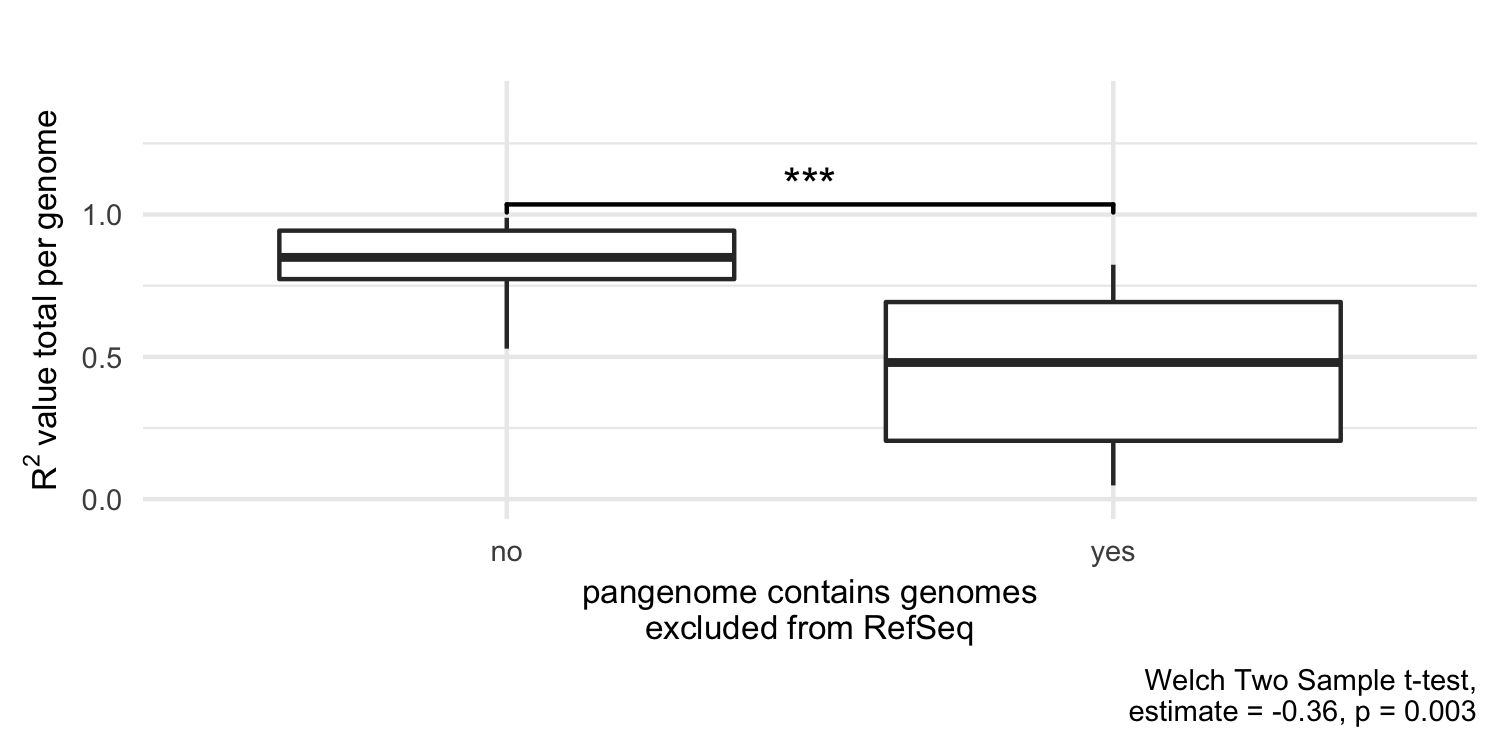

In [54]:
exclusion_plt <- ggplot(pangenome_genome_num_excluded, aes(x = excluded, y = genes_r2)) +
  geom_boxplot() +
  geom_signif(comparisons = list(c("no", "yes")), 
              map_signif_level=TRUE) +
  ylim(c(0, 1.4)) +
  theme_minimal() +
  labs(x = "pangenome contains genomes\nexcluded from RefSeq", 
       y = expression(R^2~value~total~per~genome), 
       title = "",
       caption = paste0("Welch Two Sample t-test,\nestimate = ",
                        round(ttest_pangenome_genome_num_excluded$estimate[1], digits = 2), 
                        ", p = ",
                        round(ttest_pangenome_genome_num_excluded$p.value[1], digits = 3))) +
  theme(axis.title = element_text(size = 8),
        plot.title = element_text(size = 9,  face = "italic"),
        #plot.subtitle = element_text(size = 8),
        axis.text = element_text(size = 7),
        plot.caption = element_text(size = 7))

exclusion_plt

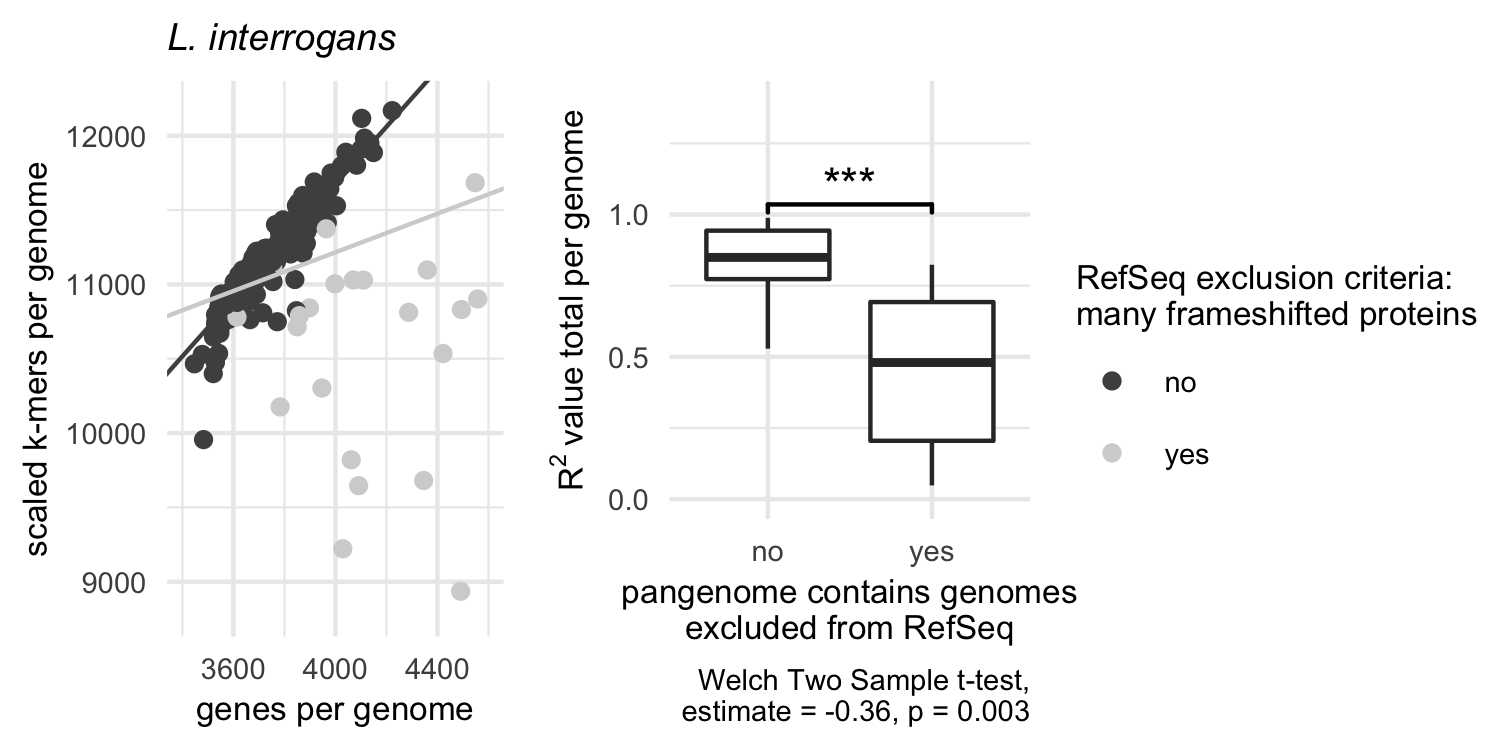

In [55]:
# adjust plot size rendered inline
options(repr.plot.width = 5, repr.plot.height = 2.5, repr.plot.res = 300)

#pdf("frameshift_fig2.pdf", width = 4, height = 2.5)
frameshift_fig <- ggarrange(plt, exclusion_plt, nrow = 1, ncol = 2,
                            common.legend = T, legend = "right")

frameshift_fig
#dev.off()

## Standard pangenomics stuff works too

In [56]:
noframeshift <- pangenome_genome_num_excluded %>%
  filter(excluded == "no")

all_summary_stats <- data.frame()
for(i in 1:nrow(noframeshift)){
  roary_file <- paste0("outputs/roary/", noframeshift$species[i], "/gene_presence_absence.csv")
  pk10_file  <- paste0("outputs/sourmash_sketch_tables/protein-k10_scaled100/", noframeshift$species[i], "_long.csv")
  roary_pagoo <- roary_2_pagoo(roary_file)
  pk10_pagoo  <- read_long_sketch_table_as_pagoo(pk10_file)
  summary_stats <- summary_stats_to_df(roary_pagoo = roary_pagoo, kmer_pagoo = pk10_pagoo,
                                       species = noframeshift$species[i])
  summary_stats$roary_alpha <- attr(roary_pagoo$pg_power_law_fit(), "alpha")
  summary_stats$kmer_alpha <- attr(pk10_pagoo$pg_power_law_fit(), "alpha")
  all_summary_stats <- bind_rows(all_summary_stats, summary_stats)
}

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.

Reading csv file

In [57]:
noframeshift

alphabet,ksize,scaled,species,genes_r2,n,excluded
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>
protein,10,100,s__Akkermansia-muciniphila,0.5600480,0,no
protein,10,100,s__CAIPMZ01-sp903861715,0.7731470,0,no
protein,10,100,s__Chlamydia-trachomatis,0.8783708,0,no
protein,10,100,s__Cuniculiplasma-divulgatum,0.9433927,0,no
protein,10,100,s__Geothrix-sp903857495,0.7955116,0,no
protein,10,100,s__Leptospirillum_A-rubarum,0.9884773,0,no
protein,10,100,s__Methanobrevibacter_A-sp900314695,0.8794639,0,no
protein,10,100,s__Prochlorococcus_A-sp000635495,0.9752915,0,no
protein,10,100,s__Pseudopelobacter-sp903852495,0.8414161,0,no


In [58]:
lm_core <- lm(kmer_core_pct ~ roary_core_pct, data = all_summary_stats) %>% glance()
r_squared_core <- round(lm_core$r.squared, digits = 2)
p_value_core <- ifelse(lm_core$p.value > 0.001, 
                  paste0("= ", round(lm_core$p.value, digits = 3)), 
                  "< 0.001")
core <- ggplot(all_summary_stats, aes(x = roary_core_pct, y = kmer_core_pct)) +
  geom_point() +
  theme_minimal() +
  xlim(c(0, 1)) + ylim(c(0, 1)) +
  theme(axis.title = element_blank(), 
        axis.text = element_text(size = 7),
        plot.subtitle = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.title.position = "plot") +
  labs(x = "", y = "", 
       title = "Core",
       subtitle = paste0("R-squared:  ", r_squared_core, " (p ", p_value_core, ")"))

In [59]:
lm_shell <- lm(kmer_shell_pct ~ roary_shell_pct, data = all_summary_stats) %>% glance()
r_squared_shell <- round(lm_shell$r.squared, digits = 2)
p_value_shell <- ifelse(lm_shell$p.value > 0.001, 
                  paste0("= ", round(lm_shell$p.value, digits = 3)), 
                  "< 0.001")
shell <- ggplot(all_summary_stats, aes(x = roary_shell_pct, y = kmer_shell_pct)) +
  geom_point() +
  theme_minimal()+
  xlim(c(0, 1)) + ylim(c(0, 1)) +
  theme(axis.title = element_blank(), 
        axis.text = element_text(size = 7),
        plot.subtitle = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.title.position = "plot") +
  labs(x = "", y = "", 
       title = "Shell",
       subtitle = paste0("R-squared:  ", r_squared_shell, " (p ", p_value_shell, ")"))


In [60]:
lm_cloud <- lm(kmer_cloud_pct ~ roary_cloud_pct, data = all_summary_stats) %>% glance()
r_squared_cloud <- round(lm_cloud$r.squared, digits = 2)
p_value_cloud <- ifelse(lm_cloud$p.value > 0.001, 
                  paste0("= ", round(lm_cloud$p.value, digits = 3)), 
                  "< 0.001")
cloud <- ggplot(all_summary_stats, aes(x = roary_cloud_pct, y = kmer_cloud_pct)) +
  geom_point() +
  theme_minimal()+
  xlim(c(0, 1)) + ylim(c(0, 1)) +
  theme(axis.title = element_blank(), 
        axis.text = element_text(size = 7),
        plot.subtitle = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.title.position = "plot") +
  labs(x = "", y = "", 
       title = "Cloud",
       subtitle = paste0("R-squared:  ", r_squared_cloud, " (p ", p_value_cloud, ")"))

In [61]:
lm_alpha <- lm(kmer_alpha ~ roary_alpha, data = all_summary_stats) %>% glance()
r_squared_alpha <- round(lm_alpha$r.squared, digits = 2)
p_value_alpha  <- ifelse(lm_alpha$p.value > 0.001, 
                  paste0("= ", round(lm_alpha$p.value, digits = 3)), 
                  "< 0.001")
alpha <- ggplot(all_summary_stats, aes(x = roary_alpha, y = kmer_alpha)) +
  geom_point() +
  theme_minimal() +
  xlim(c(0, 1)) + ylim(c(0, 1)) +
  theme(axis.title = element_blank(), 
        axis.text = element_text(size = 7),
        plot.subtitle = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.title.position = "plot") +
  labs(x = "", y = "", 
       title = "Alpha",
       subtitle = paste0("R-squared:  ", r_squared_alpha, " (p ", p_value_alpha, ")"))
# t.test(all_summary_stats$kmer_alpha, all_summary_stats$roary_alpha, paired = T)

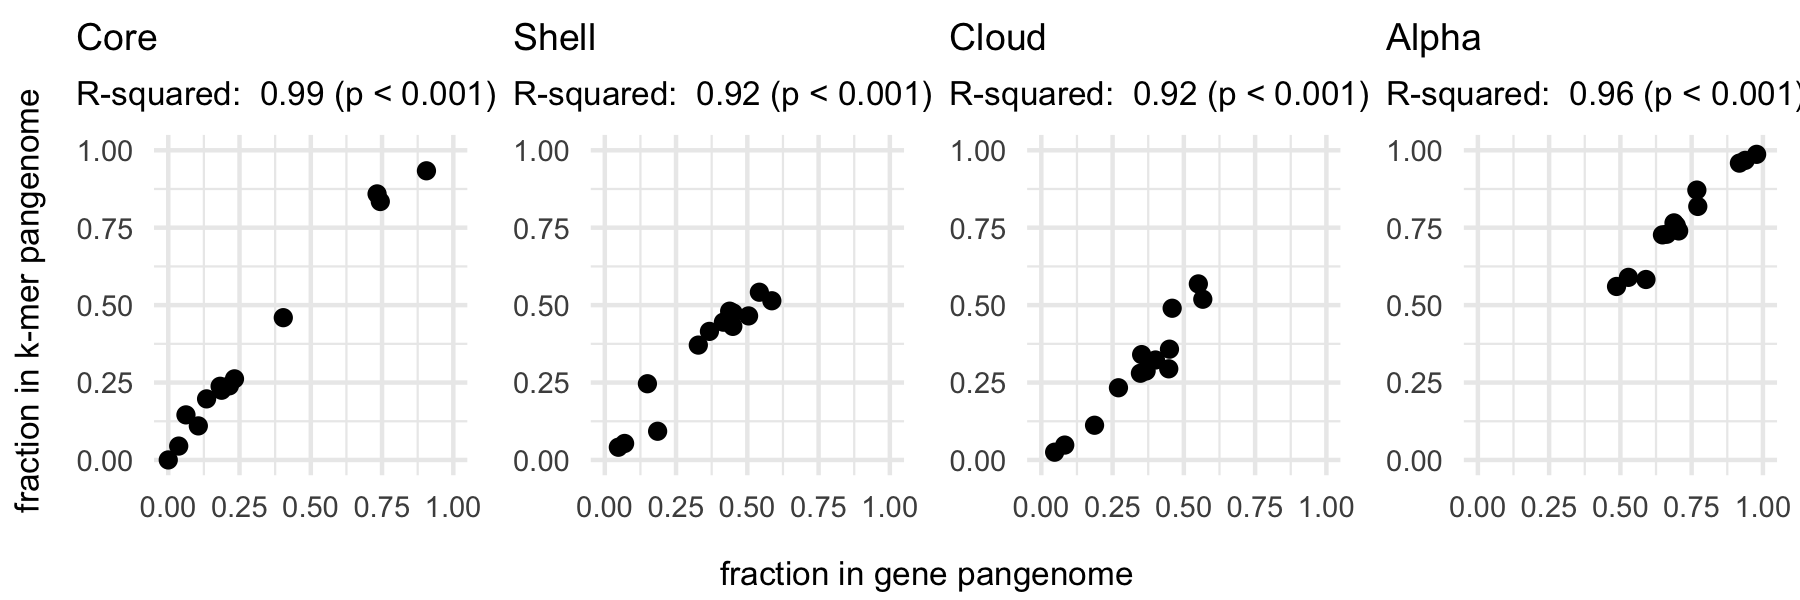

In [62]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 2., repr.plot.res = 300)

#pdf("pg_fig.pdf", height = 3.5, width = 4)
gg_fig <- ggarrange(core, shell, cloud, alpha, ncol = 4, nrow = 1)
gg_fig_cor <- annotate_figure(gg_fig,
                bottom = text_grob("fraction in gene pangenome", size = 8),
                left = text_grob("fraction in k-mer pangenome", rot = 90, size = 8))
#dev.off()
gg_fig_cor

## Main results, but only for genomes with no frameshift

In [63]:
results_long <- results %>%
  pivot_longer(cols = genes_r2:mantel, names_to = "measurement", values_to = "statistic") %>%
  mutate(ksize = factor(ksize, levels = c("31", "7", "8", "9", "10", "11",
                                          "13", "15", "17", "27"))) %>%
  mutate(alphabet = factor(alphabet, levels = c("dna", "protein", "dayhoff", "hp"))) %>%
  mutate(measurement = factor(measurement, levels = c("genes_r2", "unique_r2", "mantel"))) %>%
  filter(species %in% noframeshift$species) %>%
  mutate(alpha_ksize = paste0(alphabet, "_", ksize)) %>%
  filter(alpha_ksize != "hp_31")

In [64]:
tmp <- results_long %>%
  group_by(alpha_ksize, measurement) %>%
  summarize(mean = mean(statistic)) %>%
  ungroup() %>%
  group_by(measurement) %>%
  mutate(rank = rank(-mean, ties.method = "min"))

tmp %>% group_by(alpha_ksize) %>% summarise(sum_rank = sum(rank)) %>% arrange(sum_rank)
tmp %>% group_by(alpha_ksize) %>% summarise(mean_rank = mean(rank)) %>% arrange(mean_rank)

`summarise()` has grouped output by 'alpha_ksize'. You can override using the `.groups` argument.


alpha_ksize,sum_rank
<chr>,<int>
protein_9,8
protein_8,10
protein_10,12
protein_7,14
dayhoff_13,16
dayhoff_15,17
protein_11,17
dayhoff_17,20
hp_27,21


alpha_ksize,mean_rank
<chr>,<dbl>
protein_9,2.666667
protein_8,3.333333
protein_10,4.000000
protein_7,4.666667
dayhoff_13,5.333333
dayhoff_15,5.666667
protein_11,5.666667
dayhoff_17,6.666667
hp_27,7.000000


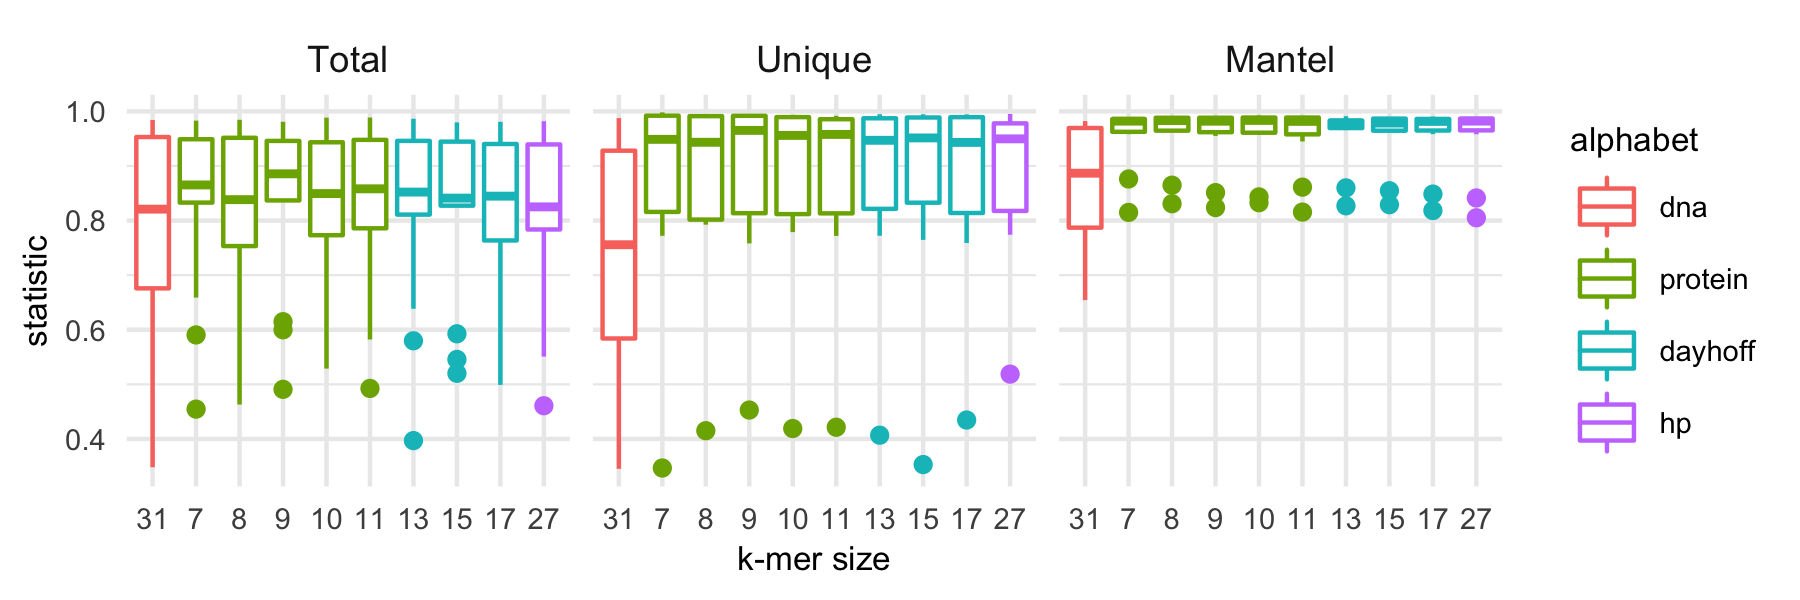

In [65]:
boxplt <- ggplot(results_long, aes(x = ksize, y = statistic, color = alphabet)) +
  geom_boxplot() +
  theme_minimal() +
  theme(axis.title = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.subtitle = element_text(size = 8),
        axis.text = element_text(size = 7),
        legend.position = "right",
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 8)) +
  labs(x = "k-mer size", fill = "encoding") +
  facet_wrap(~measurement, labeller = as_labeller(
    c(genes_r2 = "Total", unique_r2 = "Unique", mantel = "Mantel")))
    

#pdf("violin_fig.pdf", height = 2.5, width = 5)
boxplt
#dev.off()

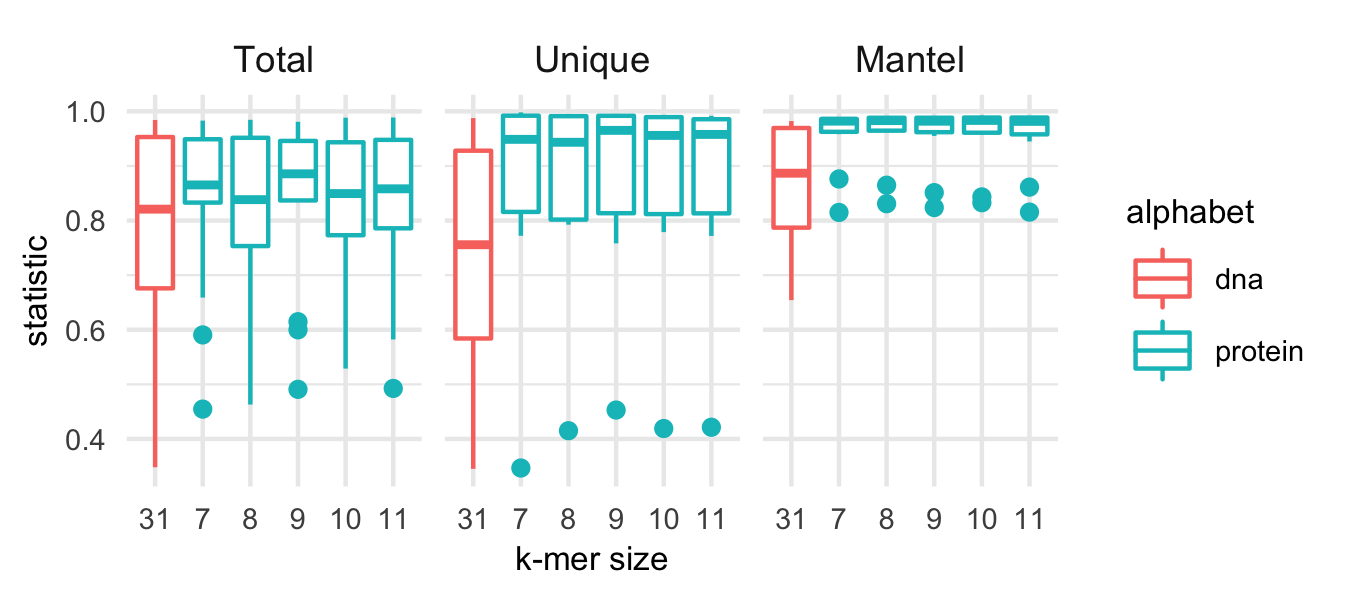

In [66]:
boxplt <- ggplot(results_long %>% filter(alphabet %in% c("dna", "protein")), 
                 aes(x = ksize, y = statistic, color = alphabet)) +
  geom_boxplot() +
  theme_minimal() +
  theme(axis.title = element_text(size = 8),
        plot.title = element_text(size = 9),
        plot.subtitle = element_text(size = 8),
        axis.text = element_text(size = 7),
        legend.position = "right",
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 8)) +
  labs(x = "k-mer size", fill = "encoding") +
  facet_wrap(~measurement, labeller = as_labeller(
    c(genes_r2 = "Total", unique_r2 = "Unique", mantel = "Mantel")))
    

# adjust plot size rendered inline
options(repr.plot.width = 4.5, repr.plot.height = 2, repr.plot.res = 300)

#pdf("violin_fig.pdf", height = 2.5, width = 5)
boxplt
#dev.off()

In [67]:
# read in containment and similarity for noframeshift
read_containment <- function(containment_path) {
  #containment_path <- "outputs/compare_pan_units/protein-k10_scaled100/s__UBA2262-sp903869265_containment.csv"
  containment <- read_csv(containment_path, show_col_types = F)
  colnames(containment) <- c("core_genes_in_core_kmers", "core_kmers_in_core_genes") 
  containment <- containment %>%
    pivot_longer(cols = starts_with("core"), names_to = "set", values_to = "containment") %>%
    filter(containment != 1) %>%
    mutate(species = gsub("_containment.csv", "", basename(containment_path)))
  return(containment)
}

In [68]:
all_containment <- Sys.glob("outputs/compare_pan_units/protein-k10_scaled100/*containment.csv") %>%
  map_dfr(read_containment) %>%
  filter(species %in% noframeshift$species)

In [69]:
all_containment %>%
  filter(containment != 0) %>%
  group_by(set) %>%
  summarize(mean_containment = mean(containment),
            sd_contaiment = sd(containment))

set,mean_containment,sd_contaiment
<chr>,<dbl>,<dbl>
core_genes_in_core_kmers,0.8388792,0.1539722
core_kmers_in_core_genes,0.7354355,0.1687445


## Plot paper figure pane

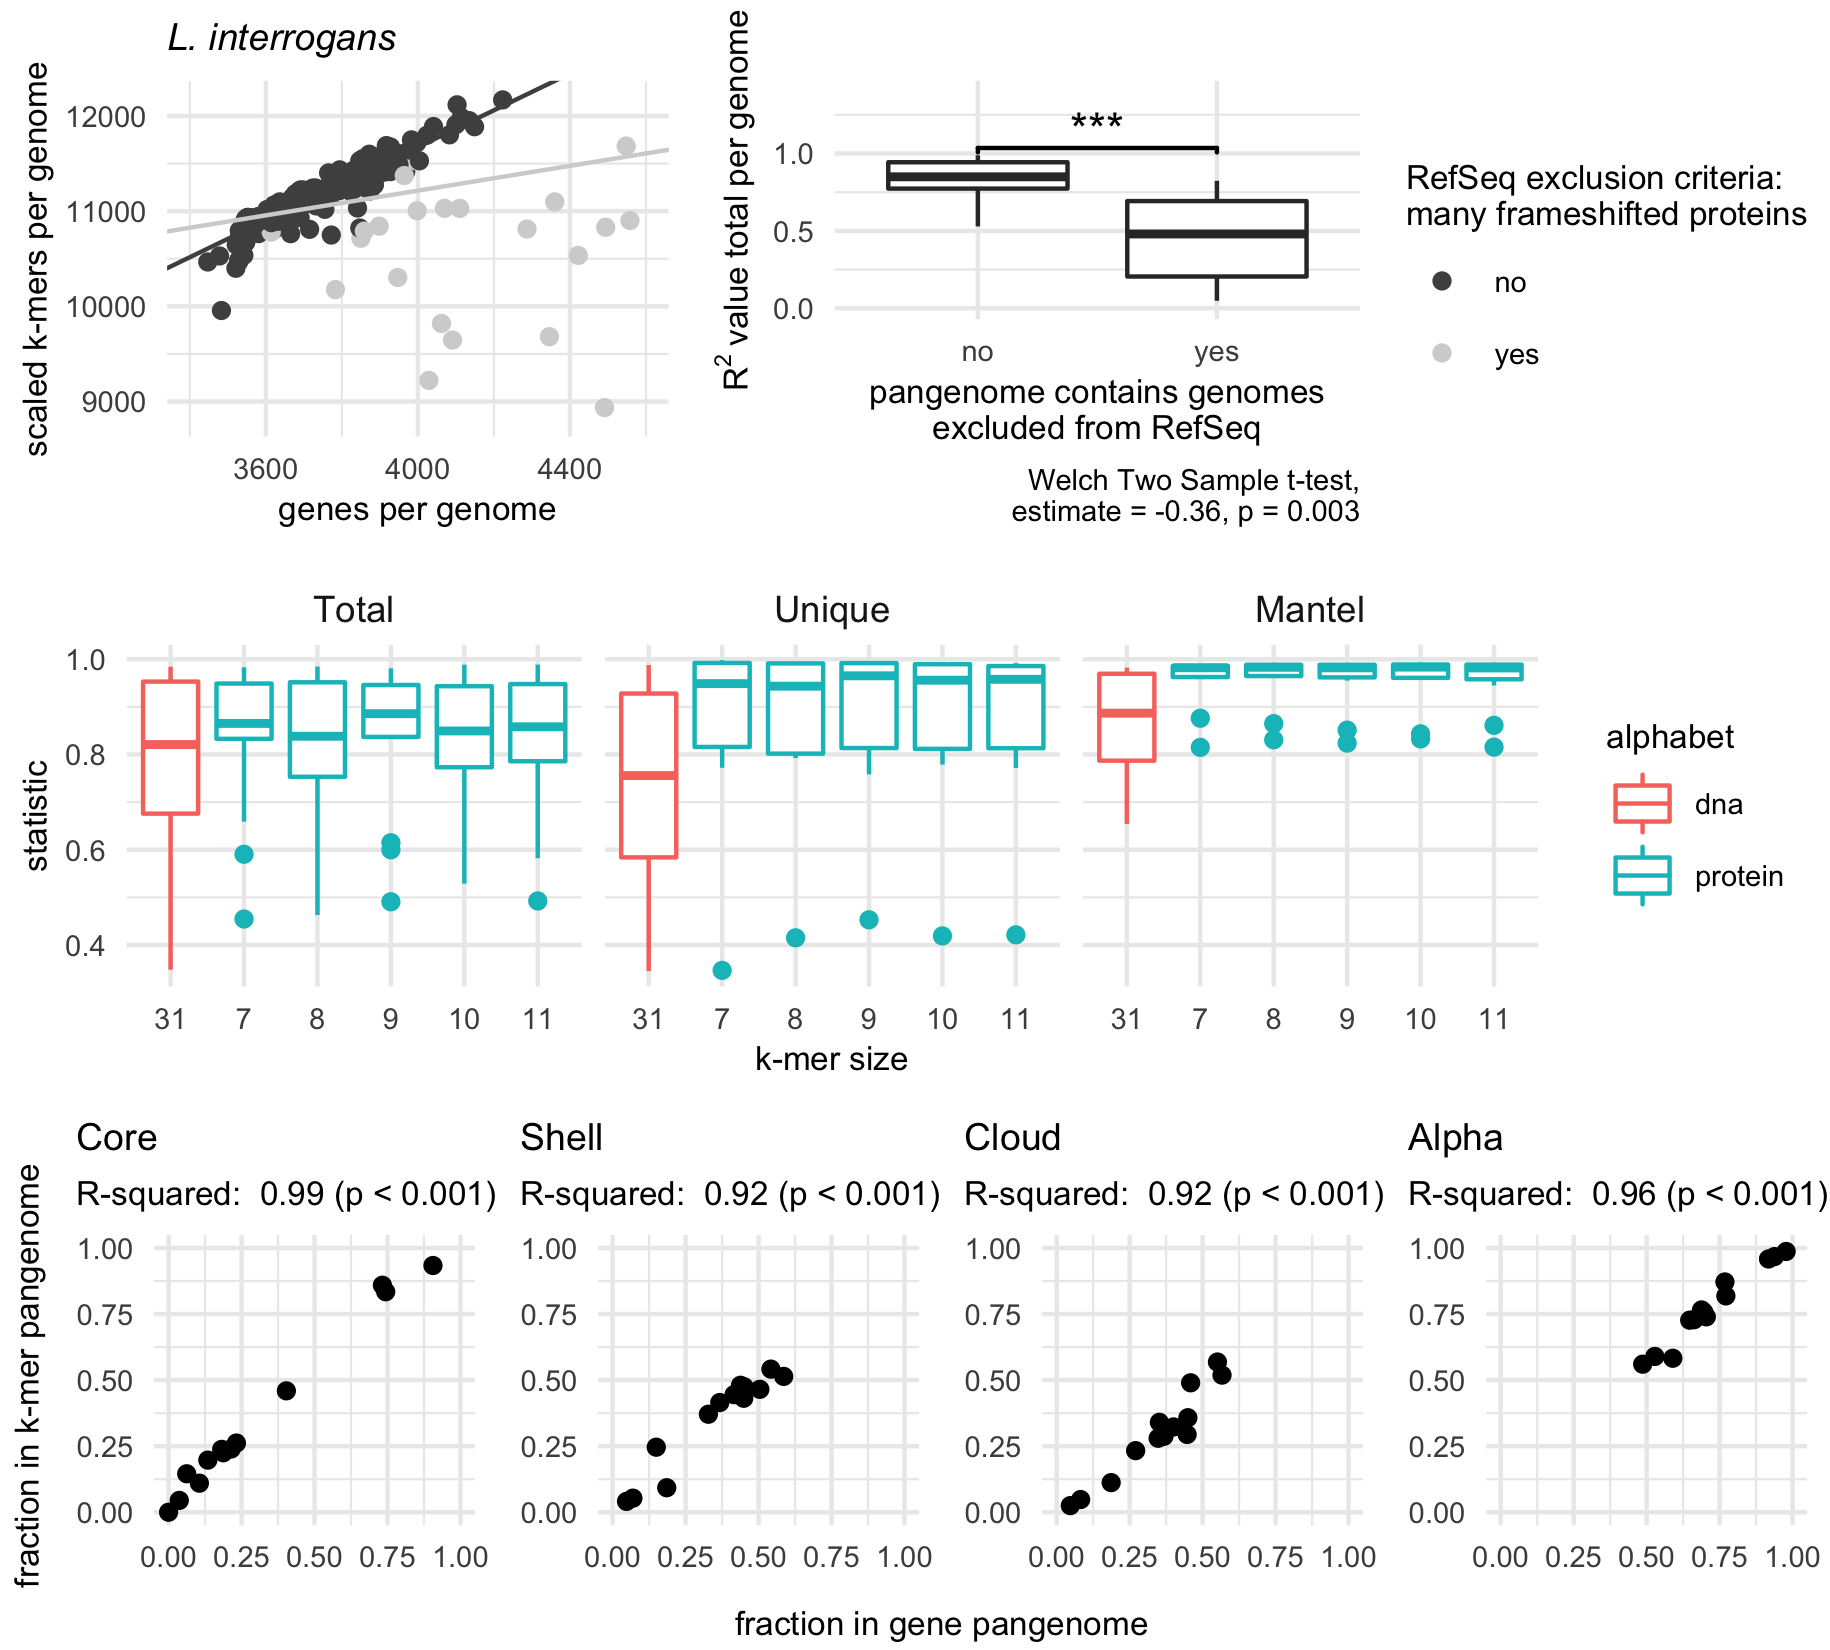

In [70]:
# adjust plot size rendered inline
options(repr.plot.width = 6.1, repr.plot.height = 5.5, repr.plot.res = 300)

ggarrange(frameshift_fig, boxplt, gg_fig_cor, nrow = 3)

In [71]:
# if run on same system with paper repo:
png("../2021-paper-metapangenomes/content/images/panmers_fig.png", width = 6.1, height = 5.5, units = "in", res = 300)
ggarrange(frameshift_fig, boxplt, gg_fig_cor, nrow = 3)
dev.off()

pdf 
  2

# Extra goodies

## Pangenome figure

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



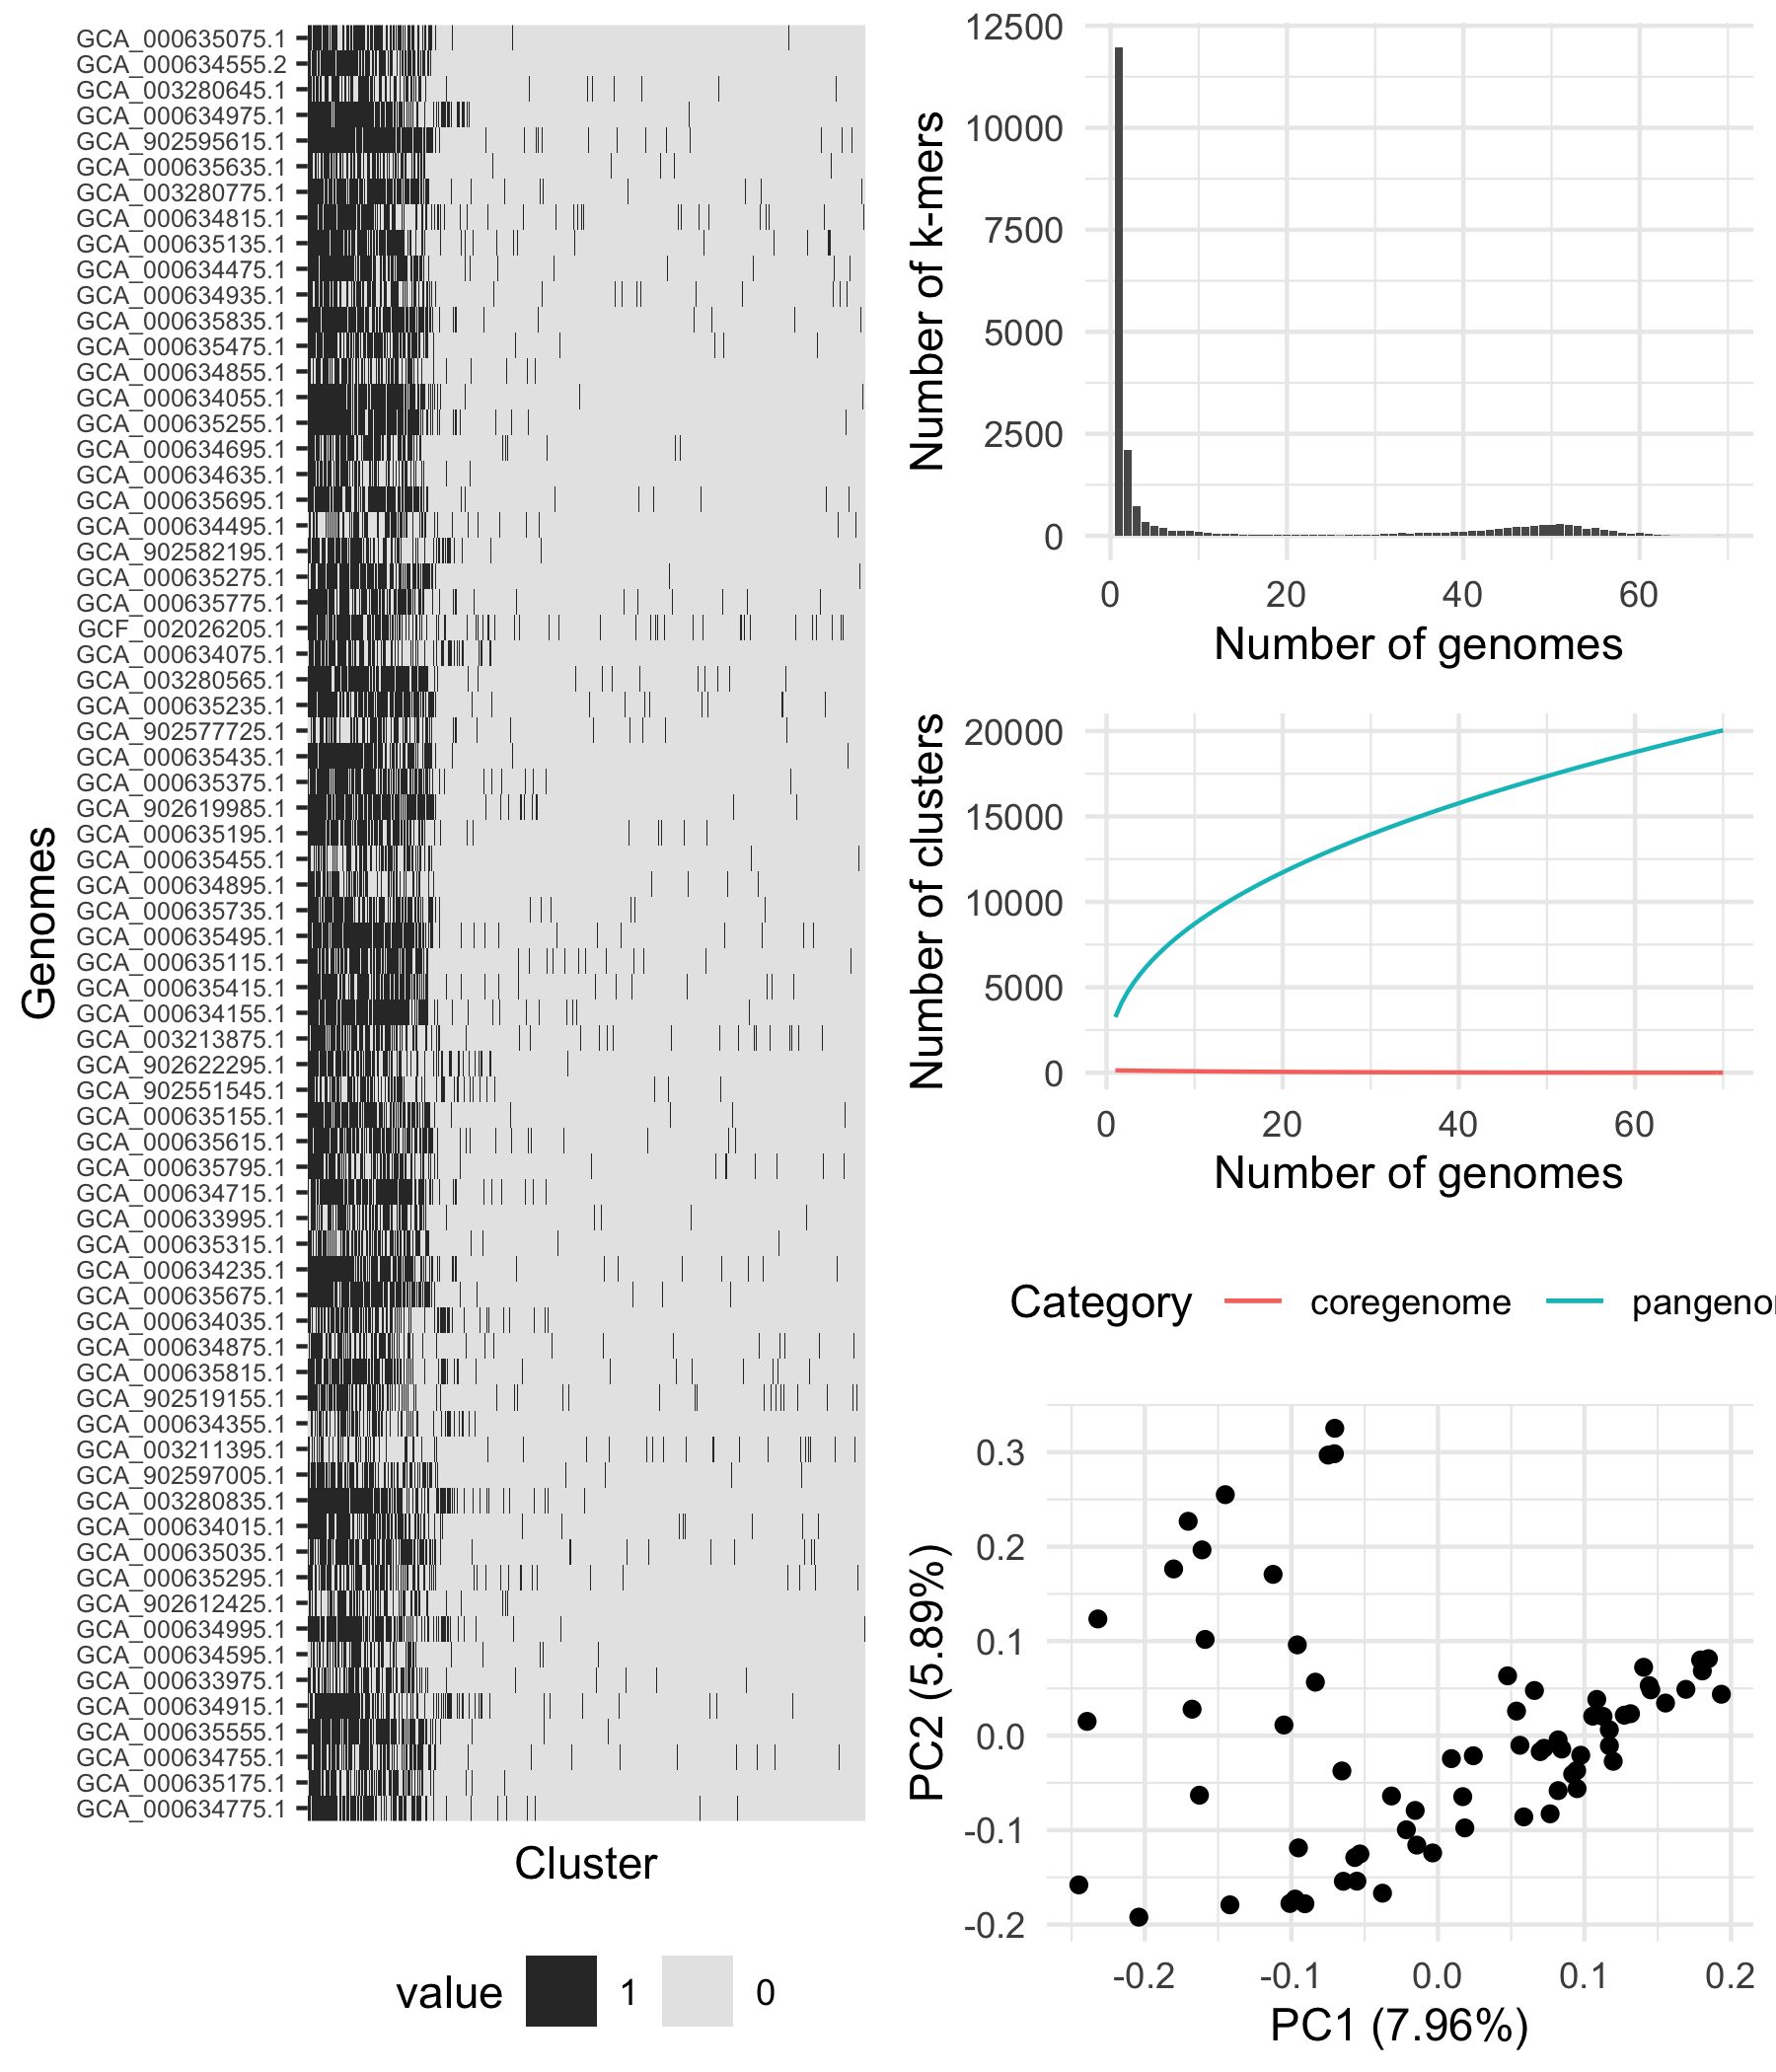

In [96]:
pk10_prochlorococcus_pagoo  <- read_long_sketch_table_as_pagoo("outputs/sourmash_sketch_tables/protein-k10_scaled100/s__Prochlorococcus_A-sp000635495_long.csv")

barplot <- pk10_prochlorococcus_pagoo$gg_barplot() + theme_minimal() + labs(y = "Number of k-mers")
binmap <- pk10_prochlorococcus_pagoo$gg_binmap() + theme(axis.text.y = element_text(size = 6), legend.position = "bottom")  + labs(y = "Genomes", y = "K-mer")
curves <- pk10_prochlorococcus_pagoo$gg_curves() + theme_minimal() + theme(legend.position = "bottom")
pca <- pk10_prochlorococcus_pagoo$gg_pca() + theme_minimal()

# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 300)

ggarrange(binmap, ncol = 2, 
          ggarrange(barplot, curves, pca, nrow = 3))

## Corrmap all genome pairs

In [97]:
make_roary_mers_pairs <- function(roary, mers, species){
  total_genes_per_genome <- rowSums(roary)
  total_mers_per_genome <- rowSums(mers)
  
  total_per_genome <- data.frame(total_genes_per_genome, total_mers_per_genome)
  
  total_per_genome <- total_per_genome %>%
    rownames_to_column("genome") %>%
    mutate(species = species)
}

In [98]:
if(!file.exists("outputs/species_pairs/all_pairs.tsv")){
  all_pairs <- data.frame()
  for(i in 1:nrow(metadata)){
    species    <- metadata$species_no_space[i]
    print(species)
    pairs_out <- paste0("outputs/species_pairs/protein-k10_scaled100/", species, ".tsv")
    if (!file.exists(pairs_out)) {
      print("generating pairs.")
      roary_file <- paste0("outputs/roary/", species, "/gene_presence_absence.csv")
      pk10_file  <- paste0("outputs/sourmash_sketch_tables/protein-k10_scaled100/", species, "_wide.feather")
      roary_species <- read_roary_presence_absence(roary_file)
      pk10_species  <- read_mers_presence_absence(pk10_file)
      pairs <- make_roary_mers_pairs(roary = roary_species,
                                     mers = pk10_species,
                                     species = species)
      write_tsv(pairs, file = pairs_out)
    } else {
      print("reading existing pairs.")
      pairs <- read_tsv(pairs_out)
    }
    all_pairs <- bind_rows(pairs, all_pairs)
  }
  write_tsv(all_pairs, file = "outputs/species_pairs/all_pairs.tsv")
} else {
  all_pairs <- read_tsv("outputs/species_pairs/all_pairs.tsv", show_col_types = F)
}

In [99]:
all_pairs <- all_pairs %>%
  filter(species %in% metadata$species_no_space)

# remove excluded from refseq
all_pairs_filtered <- all_pairs %>%
  mutate(assembly_accession = stri_replace_last_fixed(genome, '_', '.')) %>%
  mutate(assembly_accession = gsub("gcf", "GCF", assembly_accession)) %>%
  mutate(assembly_accession = gsub("gca", "GCA", assembly_accession)) %>%
  mutate(assembly_accession_minus_version = gsub("\\.[1-9].*", "", assembly_accession)) %>%
  mutate(assembly_accession_minus_prefix = gsub("GC[FA]_", "", assembly_accession_minus_version)) %>%
  left_join(genbank, by = "assembly_accession_minus_prefix") %>%
  filter(!grepl("many frameshifted proteins", excluded_from_refseq))

In [100]:
manualcolors<-c('black','forestgreen', 'orange', 'cornflowerblue', 
                'darkolivegreen4', 'indianred1', 'tan4', 'darkblue', 
                'mediumorchid1','firebrick4', 'yellowgreen', 'wheat4', '#DDAD4B',
                'moccasin', 'mediumvioletred', 'seagreen','cadetblue1',
                "darkolivegreen1" ,"tan2" ,   "tomato3" , "#7CE3D8","gainsboro", 'red2')

In [101]:
lm_all <- lm(total_genes_per_genome ~ total_mers_per_genome, data = all_pairs_filtered) %>% glance()
r_squared_all <- round(lm_all$r.squared, digits = 2)
p_value_all <- ifelse(lm_all$p.value > 0.001, 
                  paste0("= ", round(lm_all$p.value, digits = 3)), 
                  "< 0.001")


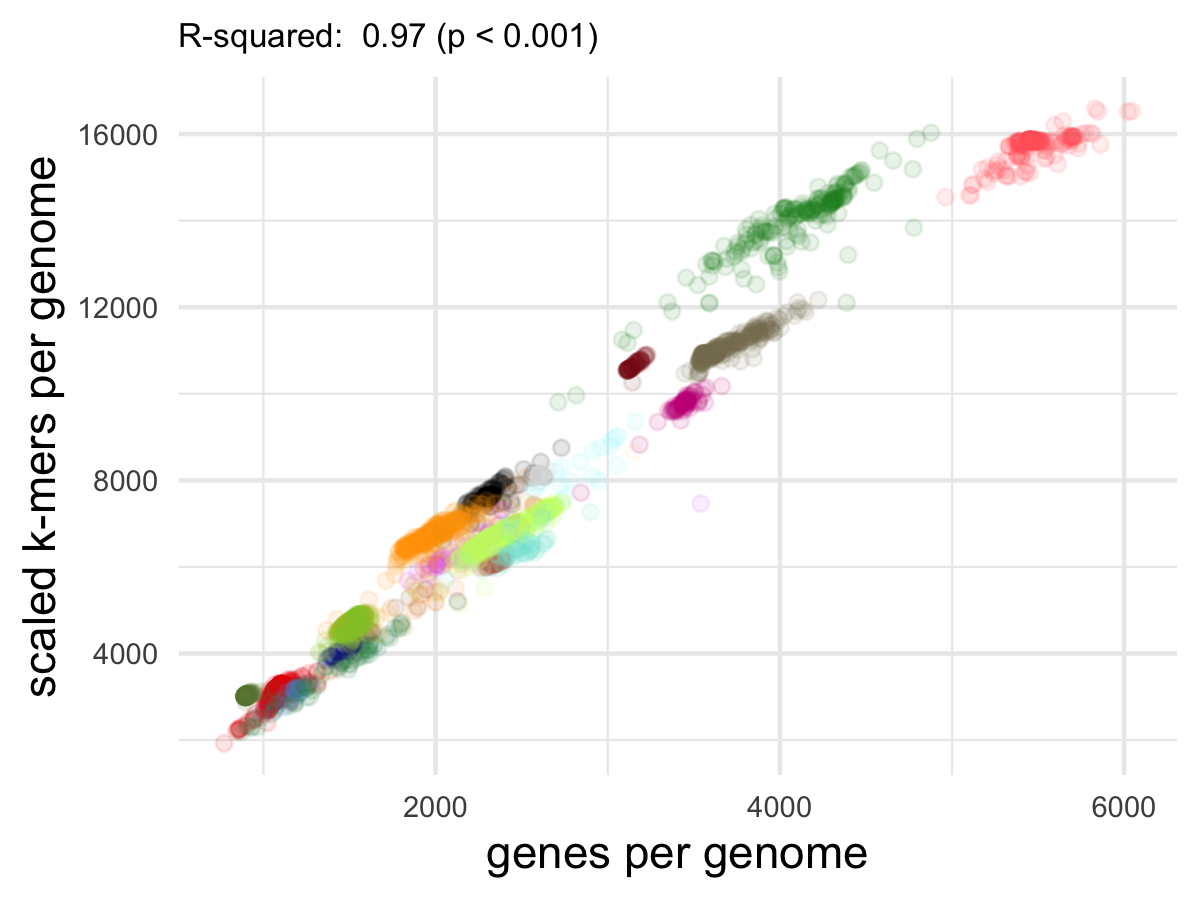

In [103]:
all_pairwise_plt <- ggplot(all_pairs_filtered, aes(x = total_genes_per_genome, y = total_mers_per_genome, color = species)) +
  geom_point(alpha = .1) +
  theme_minimal() +
  scale_color_manual(values = manualcolors) +
  theme(legend.position = "none",
        axis.text = element_text(size = 7),
        plot.subtitle = element_text(size = 8),
        plot.title = element_text(size = 9)) +
  labs(x = "genes per genome", y = "scaled k-mers per genome", 
       subtitle = paste0("R-squared:  ", r_squared_all, " (p ", p_value_all, ")"))

# adjust plot size rendered inline
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)

#pdf("all_pw_fig.pdf", height = 3, width = 4)
all_pairwise_plt
#dev.off()

In [105]:
#tmp <- all_pairs_filtered %>%
#  group_by(species) %>%
#  do(genome_fit = broom::tidy(lm(total_mers_per_genome ~ total_genes_per_genome, data = .))) %>%
#  unnest(genome_fit)
#
#all_pairs_filtered %>%
#  group_by(species) %>%
#  do(genome_fit = augment(lm(total_mers_per_genome ~ total_genes_per_genome, data = .))) %>% 
#  unnest(genome_fit)
#
#tmp <- all_pairs_filtered %>%
#  group_by(species) %>%
#  do(genome_fit = glance(lm(total_mers_per_genome ~ total_genes_per_genome, data = .))) %>% 
#  unnest(genome_fit)
#
#ggplot(tmp, aes(x = "10", y = r.squared)) +
#  geom_violin() +
#  ylim(c(0, 1))

## Nucleotide correlations

In [118]:
all_summary_stats_nuc <- data.frame()
for(i in 1:nrow(noframeshift)){
  roary_file <- paste0("outputs/roary/", noframeshift$species[i], "/gene_presence_absence.csv")
  pk10_file  <- paste0("outputs/sourmash_sketch_tables/dna-k31-scaled1000/", noframeshift$species[i], "_long.csv")
  roary_pagoo <- roary_2_pagoo(roary_file)
  pk10_pagoo  <- read_long_sketch_table_as_pagoo(pk10_file)
  summary_stats <- summary_stats_to_df(roary_pagoo = roary_pagoo, kmer_pagoo = pk10_pagoo,
                                       species = noframeshift$species[i])
  summary_stats$roary_alpha <- attr(roary_pagoo$pg_power_law_fit(), "alpha")
  summary_stats$kmer_alpha <- attr(pk10_pagoo$pg_power_law_fit(), "alpha")
  all_summary_stats_nuc <- bind_rows(all_summary_stats_nuc, summary_stats)
}

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.

Reading csv file (roary).

Processing csv file.

Loading PgR6M class object.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Checking provided cluster metadata.

Creating panmatrix.

Populating class.

Done.

Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.

Reading csv file

In [111]:
all_summary_stats_nuc

roary_total,roary_core,roary_shell,roary_cloud,roary_core_pct,roary_shell_pct,roary_cloud_pct,kmer_total,kmer_core,kmer_shell,kmer_cloud,kmer_core_pct,kmer_shell_pct,kmer_cloud_pct,species,roary_alpha,kmer_alpha
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
10949,1472,4555,4922,0.13444150,0.41601973,0.44953877,10585,748,6620,3217,0.070666037,0.62541332,0.30392064,s__Akkermansia-muciniphila,0.6410348,0.7082814
2698,505,1463,730,0.18717569,0.54225352,0.27057079,2123,260,1419,444,0.122468205,0.66839378,0.20913801,s__CAIPMZ01-sp903861715,0.7601421,0.8243482
2094,845,313,936,0.40353391,0.14947469,0.44699140,1810,642,667,501,0.354696133,0.36850829,0.27679558,s__Chlamydia-trachomatis,0.7842437,0.8730866
3852,895,1414,1543,0.23234683,0.36708204,0.40057113,3299,557,1374,1368,0.168839042,0.41648985,0.41467111,s__Cuniculiplasma-divulgatum,0.6864394,0.6556208
3427,3104,163,160,0.90574847,0.04756347,0.04668807,3410,3218,136,56,0.943695015,0.03988270,0.01642229,s__Geothrix-sp903857495,0.9791571,0.9905833
5381,979,2424,1978,0.18193644,0.45047389,0.36758967,4795,766,2581,1448,0.159749739,0.53826903,0.30198123,s__Leptospirillum_A-rubarum,0.7024060,0.7517447
9150,965,3002,5183,0.10546448,0.32808743,0.56644809,8163,505,3295,4363,0.061864511,0.40365062,0.53448487,s__Methanobrevibacter_A-sp900314695,0.5199416,0.5362570
7681,0,3450,4231,0.00000000,0.44916027,0.55083973,9212,0,3496,5716,0.000000000,0.37950499,0.62049501,s__Prochlorococcus_A-sp000635495,0.5876148,0.4789225
7358,1577,3223,2558,0.21432454,0.43802664,0.34764882,5190,1293,2585,1312,0.249132948,0.49807322,0.25279383,s__Pseudopelobacter-sp903852495,0.7043939,0.7899979


## Compare scaled = 1 to scaled = 100

In [113]:
scaled1_genes <- Sys.glob("outputs/correlate_pan_units/scaled1/*genes.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  select(species, genes1_r2 = adj.r.squared, genes1_p = p.value)
scaled1_mantel <-Sys.glob("outputs/correlate_pan_units/scaled1/*mantel.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  select(species, mantel1 = statistic, mantel1_p = signif)
scaled1_unique <-Sys.glob("outputs/correlate_pan_units/scaled1/*unique.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  select(species, unique1_r2 = adj.r.squared, unique1_p = p.value)
scaled1 <- left_join(scaled1_genes, scaled1_unique) %>%
  left_join(scaled1_mantel)

scaled100_genes <- Sys.glob("outputs/correlate_pan_units/scaled100/*genes.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  select(species, genes100_r2 = adj.r.squared, genes100_p = p.value)
scaled100_mantel <-Sys.glob("outputs/correlate_pan_units/scaled100/*mantel.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  select(species, mantel100 = statistic, mantel100_p = signif)
scaled100_unique <-Sys.glob("outputs/correlate_pan_units/scaled100/*unique.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  select(species,unique100_r2 = adj.r.squared, unique100_p = p.value)
scaled100 <- left_join(scaled100_genes, scaled100_unique) %>%
  left_join(scaled100_mantel)

all <- left_join(scaled1, scaled100, by = "species") %>%
  filter(!is.na(genes100_r2))

Joining, by = "species"
Joining, by = "species"
Joining, by = "species"
Joining, by = "species"


In [115]:
summary(lm(genes100_r2 ~ genes1_r2, data = all))


Call:
lm(formula = genes100_r2 ~ genes1_r2, data = all)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.018675 -0.005565  0.002076  0.006340  0.013645 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.04228    0.02160  -1.957   0.0981 .  
genes1_r2    1.03387    0.02570  40.235 1.58e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01163 on 6 degrees of freedom
Multiple R-squared:  0.9963,	Adjusted R-squared:  0.9957 
F-statistic:  1619 on 1 and 6 DF,  p-value: 1.576e-08


In [116]:
summary(lm(mantel100 ~ mantel1, data = all))


Call:
lm(formula = mantel100 ~ mantel1, data = all)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.003876 -0.002248 -0.000383  0.001886  0.005929 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.05465    0.02882  -1.896    0.107    
mantel1      1.05393    0.02990  35.248 3.48e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003618 on 6 degrees of freedom
Multiple R-squared:  0.9952,	Adjusted R-squared:  0.9944 
F-statistic:  1242 on 1 and 6 DF,  p-value: 3.475e-08


In [117]:
summary(lm(unique100_r2 ~ unique1_r2, data = all))


Call:
lm(formula = unique100_r2 ~ unique1_r2, data = all)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0046538 -0.0035838 -0.0000305  0.0022068  0.0073687 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.02871    0.02529  -1.135      0.3    
unique1_r2   1.02699    0.02640  38.906 1.93e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004481 on 6 degrees of freedom
Multiple R-squared:  0.9961,	Adjusted R-squared:  0.9954 
F-statistic:  1514 on 1 and 6 DF,  p-value: 1.926e-08
